### 파일을 사용하기 위해 드라이브의 폴더와 연동합니다.

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 분석에 사용할 기본적인 패키지들을 로드합니다.

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### 분석에 사용할 데이터셋을 로드하고 데이터 구조를 살펴봅니다.

In [96]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/영화 리뷰 감성분석 경진대회(Basic)/Data/train.csv')
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [97]:
print(train.isna().sum().sum()) # 결측값 확인 - 결측값 없음
print(train.document.nunique()) # 중복 여부 확인 - 중복값 없음
print(train.columns)

0
5000
Index(['id', 'document', 'label'], dtype='object')


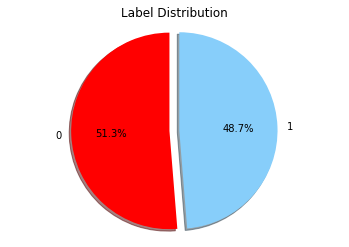

In [98]:
# label 분포도 확인 - 균등
labels = list(train['label'].unique())
sizes = train['label'].value_counts()
colors = ['red', 'lightskyblue']
explode = (0, 0.1)
plt.title('Label Distribution')
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

### 훈련데이터에 결측값도 없고, 중복값도 없으며, 분포가 균등한 것을 확인했습니다.
### 본격적인 분석을 시작하기위해 토큰 사전을 만들어봅시다.
### 이번 분석에서는 Konlpy의 가장 기본적인 분석기인 Okt를 사용할 예정입니다.

In [99]:
# 불필요한 열 삭제 후 분석에 사용할 데이터셋 선언
df_train = train.drop(['id'], axis = 1).copy()
df_train.head()

,document,label
0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [100]:
# 정규표현식을 사용하여 한글과 숫자, 영어를 제외하고 전부 삭제
df_train['document'] = df_train['document'].str.replace('[^ㄱ-하-ㅣ가-힣A-Za-z ]', ' ')
df_train.head()

,document,label
0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


In [101]:
# colab환경에서 konlpy를 사용하기 위해 konlpy설치
# 로컬환경에서 분석을 원하시는 분은 해당 사이트를 참조하면 환경조성하시기 바랍니다.
# https://byeon-sg.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-konlpy-%EC%84%A4%EC%B9%98-%EC%98%A4%EB%A5%98-okt%EC%97%90%EB%9F%AC-already-loaded-in-another-classloader-SystemErro-1
!pip3 install konlpy

In [102]:
# 한글 처리
from konlpy.tag import Okt
okt = Okt()
word_dict = dict()

# 토큰화 작업후 단어의 개수 세기
for review in df_train.document:
    word_list = okt.morphs(review)
    for word in word_list:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

# operator를 사용한 단어사전 정렬(빈도수 기준 내림차순 정렬)
import operator

# key=operator.itemgetter(0) - 키 값으로 정렬 / key=operator.itemgetter(1) value 값으로 정렬
words = sorted(word_dict.items(), key=operator.itemgetter(1), reverse = True)
# print(len(words))
# 각 단어별로 인덱스 번호 부여
word_index = dict()
word_index['NA'] = 0
cnt = 1
# 전부 사용
for word in words:
    word = word[0]
    word_index[word] = cnt
    cnt += 1 
# # 빈도수가 높은 단어만 사용
# for i in range(5000):
#     word = words[i][0]
#     word_index[word] = cnt
#     cnt += 1 

### 단어사전을 만든 후에는 리뷰데이터의 벡터화 및 패딩 작업이 필요합니다.
### 케라스를 활용해서 해도 상관은 없으나 직접 한번 해보도록 합시다.
### 쉽게 진행하기 위해 단어사전과 문장길이는 그냥 단어사전 전체와 최대문장길이로 맞추겠습니다.

In [103]:
# 훈련데이터 셋 최대 문장길이 확인
df_train['token'] = df_train.document.apply(lambda x: okt.morphs(x))
# max_length = 0
# for token_list in df_train.token:
#     sample = len(token_list)
#     if max_length < sample:
#         max_length = sample
# max_length
max_length = 12

In [104]:
# 벡터화 및 패딩 작업 진행
def tk_vect(token_list, max_length):
    vector_list = []
    for token in token_list:
        if token in word_index:
            vector_list.append(word_index[token])
        else:
            vector_list.append(word_index['NA'])
    if len(vector_list) < max_length:
        for _ in range(len(vector_list), max_length):
            vector_list.append(word_index['NA'])
    if len(vector_list) > max_length:
            vector_list = vector_list[:max_length] 
    return vector_list

df_train['vectorization'] = df_train['token'].apply(lambda x: tk_vect(x, max_length))
df_train.head()

,document,label,token,vectorization
0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,"[영상, 이나, 음악, 이, 이쁘다, 해도, 미화, 시킨, 불륜, 일, 뿐]","[253, 184, 168, 2, 1400, 371, 968, 1401, 969, ..."
1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1,"[히치콕, 이, 이, 영화, 를, 봤다면, 분명, 박수, 를, 쳤을듯]","[2415, 2, 2, 1, 9, 1803, 760, 970, 9, 3857, 0, 0]"
2,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1,"[괜찮은, 음악, 영화, 가, 또, 나왔군요, 따뜻한, 겨울, 이, 될, 것, 같아요]","[409, 168, 1, 4, 113, 2416, 619, 1804, 2, 435,..."
3,아무래도 년도지난작품이라 지금보기는너무유치하다,0,"[아무래도, 년도, 지난, 작품, 이라, 지금, 보기, 는, 너무, 유치하다]","[3858, 393, 1402, 91, 372, 127, 185, 8, 10, 97..."
4,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0,"[지금, 까지의, 영화, 들, 이, 그랬듯, 이, 영화, 역시, 일본, 에, 대한,...","[127, 2417, 1, 11, 2, 3859, 2, 1, 119, 275, 5,..."


### 토큰화 - 벡터화 - 패딩 작업이 완료되었습니다.
### 본격적인 분석을 진행해봅시다. 
### 가장 기초적인 분류모델인 로지스틱 회귀모델을 사용해봅시다.

In [105]:
from sklearn.linear_model import LogisticRegression #모델 불러오기
from sklearn.metrics import accuracy_score 

lr = LogisticRegression(max_iter = 500) #객체에 모델 할당
lr.fit(list(df_train.vectorization), list(df_train.label)) #모델 학습
pred = lr.predict(list(df_train.vectorization))
accuracy_score(df_train.label, pred)

0.5396

### 정확도가 0.5354정도로 좋지 않습니다.
### 사실 로지스틱회귀로 분석을 하면 단어의 유사도 및 문맥을 고려할 수 없기때문에
### 좋은 결과를 기대하기 어렵습니다. 딥러닝 모델을 활용하여 분석을 진행해봅시다.

In [106]:
# 딥러닝 모델을 사용하기 위해서는 넘파이 구조로 자료형을 변환해주어야 합니다.
deep_train = df_train[['vectorization', 'label']].copy()
for i in range(max_length):
    deep_train[f'{i}'] = deep_train.vectorization.apply(lambda x: x[i]) 
deep_train.drop(['vectorization'], axis = 1, inplace = True)
deep_train.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11
0,0,253,184,168,2,1400,371,968,1401,969,179,144,0
1,1,2415,2,2,1,9,1803,760,970,9,3857,0,0
2,1,409,168,1,4,113,2416,619,1804,2,435,30,344
3,0,3858,393,1402,91,372,127,185,8,10,971,0,0
4,0,127,2417,1,11,2,3859,2,1,119,275,5,254


In [107]:
# 분석에 사용할 데이터를 훈련 데이터와 평가 데이터로 분할 - 여기서는 평가데이터를 검증 데이터로 사용할 예정입니다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(deep_train.drop(['label'], axis = 1), deep_train[['label']], \
                                                    test_size = 0.2, stratify =deep_train[['label']], random_state = 7)

In [108]:
# 학습데이터로 사용하기 위해 pandas파일을 numpy파일로 변환
print(X_train.shape, X_train.to_numpy().shape, X_test.shape, X_test.to_numpy().shape)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.label.to_numpy()
y_test = y_test.label.to_numpy()

(4000, 12) (4000, 12) (1000, 12) (1000, 12)


In [109]:
from tensorflow.keras.utils import to_categorical

# quality가 범주형이므로 범주형으로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 자, 분석을 위한 준비가 거의 끝났습니다. 
### 가장 기본적인 분석을 위해 Embedding층만을 활용해봅시다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
# input_length와 입력데이터의 차원을 일치시켜줘야함
# output_dim은 임베딩 벡터의 수와 일치 - 32개의 텐서로 하나의 토큰을 설명 -> 토큰간 유사도 분석
model.add(Embedding(input_dim = len(word_index), output_dim = 32, input_length = max_length))
# Flatten()층은 다차원의 배열을 1차원으로 펼쳐주는 층임.
model.add(Flatten())
# 마지막 출력층은 반드시 label의 value의 개수와 일치시켜줄 것
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()
history = model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_data = (X_test, y_test))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 12, 32)            338048    
                                                                 
 flatten_5 (Flatten)         (None, 384)               0         
                                                                 
 dense_19 (Dense)            (None, 2)                 770       
                                                                 
Total params: 338,818
Trainable params: 338,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
63/63 [==============================] - 1s 10ms/step - loss: 0.6904 - acc: 0.5655 - val_loss: 0.6844 - val_acc: 0.6380
Epoch 2/30
63/63 [==============================] - 0s 7ms/step - loss: 0.6466 - acc: 0.8773 - val_loss: 0.6415 - val_acc: 0.7670
Epoch 3/30
63/63 [==============================] 

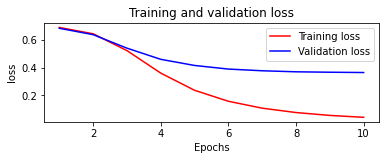

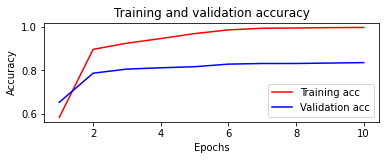

<Figure size 432x288 with 0 Axes>

In [111]:
history_dict = history.history

ax1 = plt.subplot(2, 1, 1)
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

ax2 = plt.subplot(2, 1, 2)
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

### 문맥과 맥락을 고려한 분석을 위해 LSTM 모델을 통해 분석을 진행해봅시다.

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
model = Sequential()
model.add(Embedding(input_dim = len(word_index), output_dim = 64, input_length = max_length))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(16))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()
history = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_data = (X_test, y_test))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 12, 64)            676096    
                                                                 
 lstm_16 (LSTM)              (None, 12, 32)            12416     
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 dense_18 (Dense)            (None, 2)                 34        
                                                                 
Total params: 691,682
Trainable params: 691,682
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 7s 52ms/step - loss: 0.6290 - acc: 0.6800 - val_loss: 0.4750 - val_acc: 0.7860
Epoch 2/10
63/63 [==============================